In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

Random Seed:  1123
cuda:0  will be used.



In [3]:
class Args(object):
    def __init__(self):
        self.batch_size = 32
        self.dataset = "MNIST"
        self.lr_D = 1e-3
        self.lr_G = 2e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.epochs = 30
        self.image_size = 28
        self.data_dir = "data"
        self.continuous_weight = 0.5
        self.sample_size = 100
        self.log_step = 50
        self.sample_step = 100
        self.model_path = "model"
        self.sample_path = "results"
        
args = Args()
if args.dataset == "CelebA":
    args.image_size = 64
    args.epochs = 4
    args.continuous_weight = 1.0

In [4]:
transform = transforms.Compose([
    transforms.Resize(args.image_size), 
    transforms.CenterCrop(args.image_size),
    transforms.ToTensor()])
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
if args.dataset == "MNIST":
    dataset = datasets.MNIST(os.path.join(args.data_dir, args.dataset), train="train", download=True, transform=transform)
else:
    dataset = datasets.ImageFolder(os.path.join(args.data_dir, args.dataset), transform=transform)
    
dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

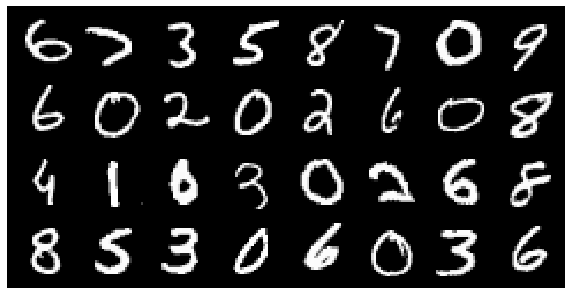

In [6]:
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device), nrow=8, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()
#plt.savefig('Training Images {}'.format(dataset))
plt.close('all')

In [7]:
#### DEFINE ####
# dim_cat_code = dimension of the categorical codes
# n_cat_code = number of the categorical codes
# n_conti_code = number of the continuous latent codes
# n_z = number of noise variables
dim_cat_code = 10
if args.dataset == "MNIST":
    n_cat_code = 1
    n_conti_code = 2
    n_z = 62 
elif args.dataset == "SVHN":
    n_cat_code = 4
    cn_conti_code = 4
    n_z = 124
elif args.dataset == "CelebA":
    n_cat_code = 10
    n_conti_code = 10
    n_z = 128

In [232]:
def init_weights(model):
    if type(model) == nn.ConvTranspose2d or type(model) == nn.Conv2d:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif type(model) == nn.BatchNorm2d:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

def denormalize(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def get_continuous_code(batch_size, n_conti_code):
    return torch.rand(batch_size, n_conti_code)*2.0 - 1.0

def get_categorical_code(batch_size, n_cat_code, dim_cat_code, fixed_i=None):
    categorical_code = torch.zeros(batch_size, n_cat_code, dim_cat_code)
    for i in range(n_cat_code):
        if fixed_i != None:
            idx = fixed_i
        else:
            idx = torch.randint(dim_cat_code, size=(batch_size,)) # [{0~dim_cat_code}] * batch_size
        categorical_code[torch.arange(0, batch_size), i, idx] = 1.0
    categorical_code = categorical_code.view(batch_size, -1)
    return categorical_code

# Draw loss graph and Save GIF

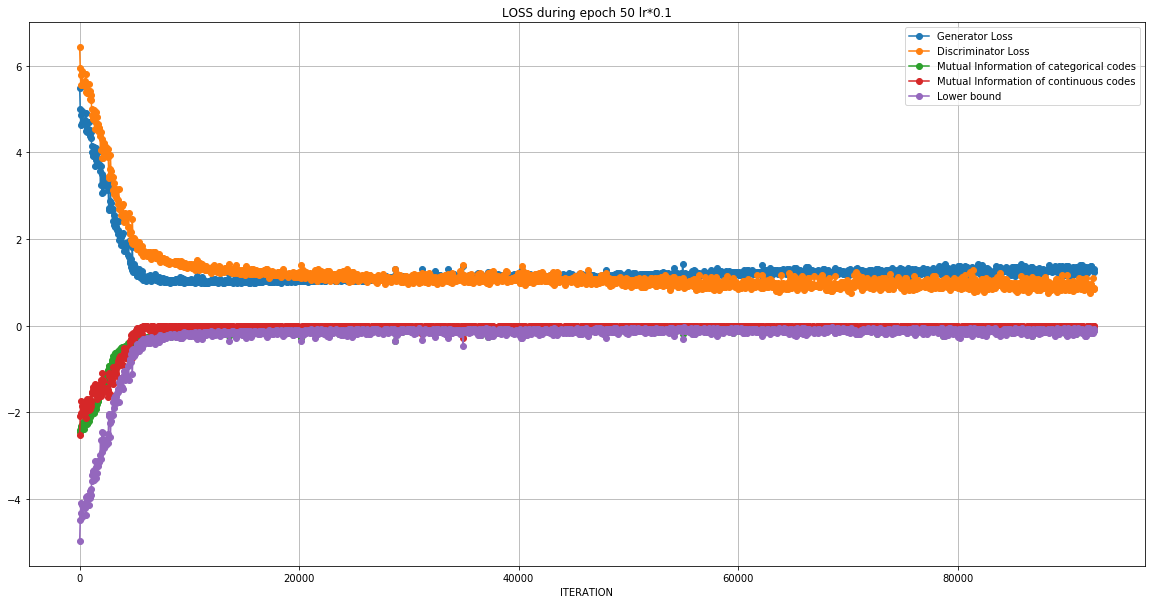

In [310]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import json
base_dir = ""
loss = json.load(open(os.path.join("model", base_dir,"loss.json")))
xaxis = list(map(lambda x: 50*x, range(0, len(loss["G"]))))

plt.figure(figsize=(20,10))
plt.plot(xaxis, loss["G"],  'o-', color='C0', label='Generator Loss')
plt.plot(xaxis, loss["D"], 'o-', color='C1',  label='Discriminator Loss')  
plt.plot(xaxis, loss["I_cat"], 'o-', color='C2',  label='Mutual Information of categorical codes')
plt.plot(xaxis, loss["I_conti"], 'o-', color='C3',  label='Mutual Information of continuous codes')
plt.plot(xaxis, loss["L1"], 'o-', color='C4',  label='Lower bound')
plt.grid()
plt.xlabel('ITERATION')
plt.title('LOSS during epoch 50 lr*0.1')
plt.legend()
plt.show()

In [311]:
imgs = [0] * 50
import glob
import imageio
for path in sorted(glob.glob(os.path.join("results", base_dir,"*1500.png"))):
    index = int(path.split("-")[1])
    img = imageio.imread(path)
    imgs[index-1] = img
    #imgs[index-1] = [plt.imshow(img, animated=True)]
imageio.mimsave(os.path.join("results", base_dir, "all.gif"), imgs)

# Manipulate the latent codes

In [312]:
from models import Generator, Discriminator
state_dict = torch.load(os.path.join("model", base_dir, "generator-50.pkl"))
generator.load_state_dict(state_dict)

<All keys matched successfully>

In [332]:
total_i = 18 + 9*10

noise = torch.randn(1, n_z).to(device)
noise = noise.repeat(total_i,1).to(device)

conti_code = get_continuous_code(1, n_conti_code).to(device)
conti_code = conti_code.repeat(total_i,1).to(device)
for i, v in enumerate([-1.5, -1.2, -1.0, -0.7, 0.5, 0.7, 1.0, 1.3, 1.5]):
    conti_code[i][0] = v
    conti_code[9+i][1] = v

#cat_code = get_categorical_code(1, n_cat_code, dim_cat_code).to(device)
#cat_code = cat_code.repeat(total_i,1).to(device)
cat_code = get_categorical_code(1, n_cat_code, dim_cat_code, fixed_i=0).to(device)
cat_code = cat_code.repeat(total_i,1).to(device)

for i in range(10):
    cat = get_categorical_code(1, n_cat_code, dim_cat_code, fixed_i=i).to(device)
    cat_code[18+9*i:18+9*(i+1), :] = cat
input_x1 = torch.cat((noise, conti_code, cat_code), dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


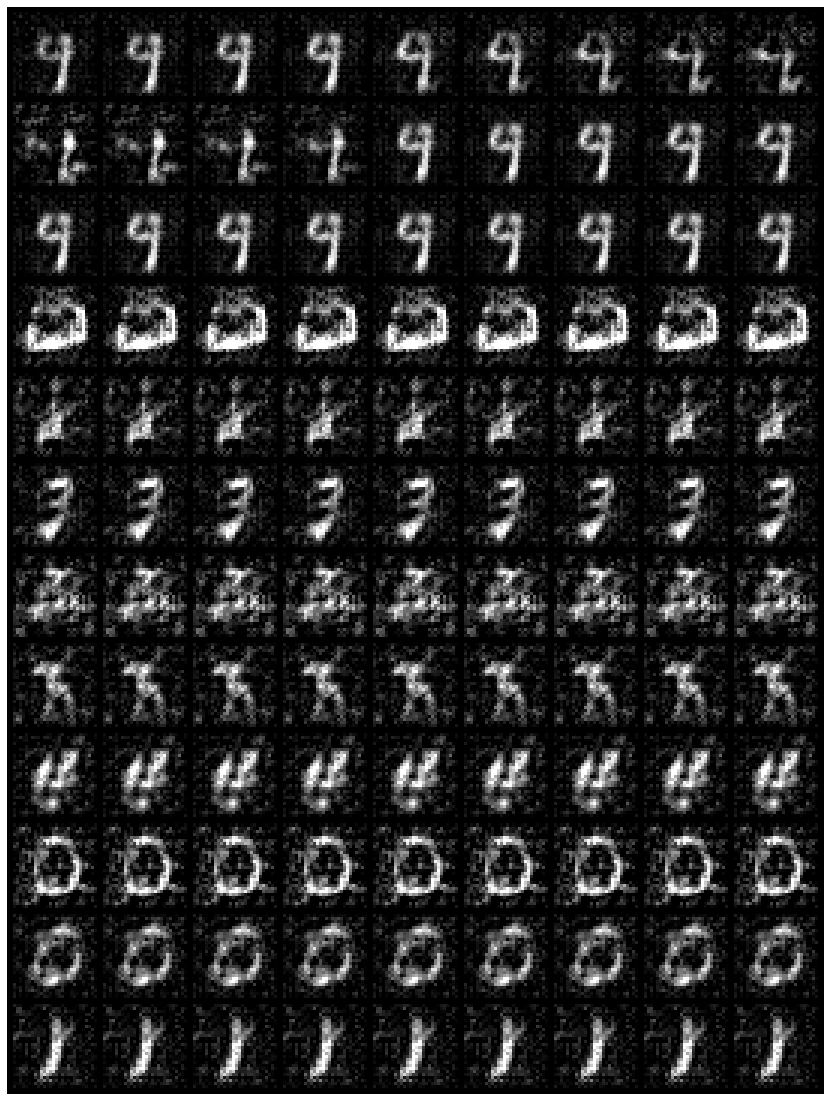

In [333]:
with torch.no_grad():
    generated_img1 = generator(input_x1).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img1, nrow=9, padding=2), (1,2,0)))
plt.savefig('manipulate50_lr0.1.jpg')
plt.show()